# Import

In [1]:
import os
import copy
import pandas as pd
import nibabel as nib
import numpy as np
import nilearn as nil
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tqdm.auto import tqdm
from scipy import ndimage, spatial
from sklearn.utils import class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix, silhouette_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, accuracy_score, cohen_kappa_score
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sn
from sklearn.preprocessing import LabelBinarizer
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
from numpy.random import seed
import SimpleITK as sitk
import warnings
warnings.filterwarnings("ignore")
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import cv2
import shutil
from nilearn import plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map, plot_anat
import csv
from skimage.transform import resize
from matplotlib import pyplot as plt

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import six
from math import ceil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Dense, Flatten
from tensorflow.keras.layers import Conv3D, AveragePooling3D, MaxPooling3D
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adadelta, Adam, SGD, Adagrad

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
      #  for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
ALPHA = 0.2
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH, CHANNELS = (96, 96, 96, 1)
BUFFER_SIZE = 1000
BATCH_SIZE = 10

# Load Data

In [5]:
fold = "5"
data = pd.read_csv('D:\\Lab\\data\\combined_data.csv')
data_train = pd.read_csv('D:\\Lab\\data2/train_p0_fold_' + fold + '.csv')
data_val = pd.read_csv('D:\\Lab\\data2\\val_p0_fold_' + fold + '.csv')
data_test = pd.read_csv('D:\\Lab\\data2\\test_p0_fold_' + fold + '.csv')
# data = data.drop(['Format'], axis=11

In [6]:
data_test[data_test.Group == 'CN'].shape

(128, 6)

In [7]:
data_test[data_test.Group == 'AD'].shape

(86, 6)

In [8]:
data_train = data_train[data_train.Group != 'MCI']
data_val = data_val[data_val.Group != 'MCI']
data_test = data_test[data_test.Group != 'MCI']

In [9]:
data_val.head()

,Links,Group,Sex,Age,ETH,RACE
0,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
1,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
2,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
3,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,63,Not Hisp/Latino,White
4,D:\Lab\ADNI\067_S_1253\MPR__GradWarp__B1_Corre...,AD,F,64,Not Hisp/Latino,White


In [10]:
seed(1)

# Preprocess

In [11]:
def bbox(mask):
    r = np.any(mask, axis=(1, 2))
    c = np.any(mask, axis=(0, 2))
    z = np.any(mask, axis=(0, 1))

    rmin, rmax = np.where(r)[0][[0, -1]]
    cmin, cmax = np.where(c)[0][[0, -1]]
    zmin, zmax = np.where(z)[0][[0, -1]]
    
    return rmin, rmax, cmin, cmax, zmin, zmax

def get_center(sitk_img):
    width, height, depth = sitk_img.GetSize()
    return sitk_img.TransformIndexToPhysicalPoint((width//2, height//2, depth//2))

def resample(image, transform):
    reference_image = image
    interpolator = sitk.sitkLinear
    default_value = 100.0
    return sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)


In [12]:
def resize_image_with_crop_or_pad(image, img_size=(64, 64, 64), **kwargs):
    """Image resizing. Resizes image by cropping or padding dimension
     to fit specified size.

    Args:
        image (np.ndarray): image to be resized
        img_size (list or tuple): new image size
        kwargs (): additional arguments to be passed to np.pad

    Returns:
        np.ndarray: resized image
    """

    assert isinstance(image, (np.ndarray, np.generic))
    assert (image.ndim - 1 == len(img_size) or image.ndim == len(img_size)), \
        'Example size doesnt fit image size'

    # Get the image dimensionality
    rank = len(img_size)

    # Create placeholders for the new shape
    from_indices = [[0, image.shape[dim]] for dim in range(rank)]
    to_padding = [[0, 0] for dim in range(rank)]

    slicer = [slice(None)] * rank

    # For each dimensions find whether it is supposed to be cropped or padded
    for i in range(rank):
        if image.shape[i] < img_size[i]:
            to_padding[i][0] = (img_size[i] - image.shape[i]) // 2
            to_padding[i][1] = img_size[i] - image.shape[i] - to_padding[i][0]
        else:
            from_indices[i][0] = int(np.floor((image.shape[i] - img_size[i]) / 2.))
            from_indices[i][1] = from_indices[i][0] + img_size[i]

        # Create slicer object to crop or leave each dimension
        slicer[i] = slice(from_indices[i][0], from_indices[i][1])

    # Pad the cropped image to extend the missing dimension
    return np.pad(image[slicer[0],slicer[1],slicer[2]], to_padding, **kwargs)

In [13]:
def resize_img(img):
    desired_depth = IMAGE_DEPTH
    desired_width = IMAGE_WIDTH
    desired_height = IMAGE_HEIGHT
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def apply_mask(filename):
    
    folder = filename.split('\\')
    image_name = folder[-1]
    imagename = 'D:\\Lab\\mask\\' + 'w' + filename.split('\\')[-1][2:-4] + 'mask.nii'
    atlasname = '\\'.join(folder[:8]) + '\\aal3_' + image_name[2:]
    
    sitk_img = sitk.ReadImage(filename)
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask1 = sitk.ReadImage(imagename)
    sitk_mask1 = sitk.Resample(sitk_mask1, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask1.GetPixelID()) 
    baseline = sitk.GetArrayFromImage(sitk_mask1)
    
    sitk_atlas = sitk.ReadImage(atlasname)
    sitk_atlas = sitk.Resample(sitk_atlas, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_atlas.GetPixelID()) 
    atlas = sitk.GetArrayFromImage(sitk_atlas)
   
    img = np.swapaxes(img, 0,2)
    baseline = np.swapaxes(baseline, 0,2)
    atlas = np.swapaxes(atlas, 0,2)
    # baseline = np.zeros(img.shape)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    # rmin, rmax, cmin, cmax, zmin, zmax = bbox(mask_img)
    baseline = baseline[rmin:rmax, cmin:cmax, zmin:zmax]
    atlas = atlas[rmin:rmax, cmin:cmax, zmin:zmax]
    # mask_img2 = mask_img2[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
        baseline = baseline[diff_r//2:r-diff_r//2,:,:]
        atlas = atlas[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
        baseline = baseline[:,diff_c//2:c-diff_c//2,:]
        atlas = atlas[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
        baseline = baseline[:,:,diff_z//2:z-diff_z//2]
        atlas = atlas[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    baseline = resize_image_with_crop_or_pad(baseline, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    atlas = resize_image_with_crop_or_pad(atlas, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    # baseline = np.zeros(img.shape)
    
    return img, baseline, atlas

def apply_mask_one(filename):
    
    sitk_img = sitk.ReadImage(filename)
    img = sitk.GetArrayFromImage(sitk_img)
   
    img = np.swapaxes(img, 0,2)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    
    return img

def apply_mask_baseline(filename, baseline_filename):
    
    folder = filename.split('\\')
    image_name = folder[-1]
    atlasname = '\\'.join(folder[:8]) + '\\aal3_' + image_name[2:]
    
    sitk_img = sitk.ReadImage(filename)
    img = sitk.GetArrayFromImage(sitk_img)

    sitk_mask1 = sitk.ReadImage(baseline_filename)
    sitk_mask1 = sitk.Resample(sitk_mask1, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_mask1.GetPixelID()) 
    baseline = sitk.GetArrayFromImage(sitk_mask1)
    
    sitk_atlas = sitk.ReadImage(atlasname)
    sitk_atlas = sitk.Resample(sitk_atlas, sitk_img, sitk.Transform(), sitk.sitkNearestNeighbor, 0, sitk_atlas.GetPixelID()) 
    atlas = sitk.GetArrayFromImage(sitk_atlas)
   
    img = np.swapaxes(img, 0,2)
    baseline = np.swapaxes(baseline, 0,2)
    atlas = np.swapaxes(atlas, 0, 2)
    
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    baseline = baseline[rmin:rmax, cmin:cmax, zmin:zmax]
    atlas = atlas[rmin:rmax, cmin:cmax, zmin:zmax]
    
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
        baseline = baseline[diff_r//2:r-diff_r//2,:,:]
        atlas = atlas[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
        baseline = baseline[:,diff_c//2:c-diff_c//2,:]
        atlas = atlas[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
        baseline = baseline[:,:,diff_z//2:z-diff_z//2]
        atlas = atlas[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    baseline = resize_image_with_crop_or_pad(baseline, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    atlas = resize_image_with_crop_or_pad(atlas, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    # baseline = np.zeros(img.shape)
    
    return img, baseline, atlas

def apply_mask_img(filename):
    img = nib.load(filename).get_fdata()
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    return img

def apply_mask_val(filename, labels):
    img = nib.load(filename.numpy().decode()).get_fdata()
    rmin, rmax, cmin, cmax, zmin, zmax = bbox(img)
    img = img[rmin:rmax, cmin:cmax, zmin:zmax]
    r,c,z = img.shape
    diff_r, diff_c, diff_z = r-IMAGE_HEIGHT, c-IMAGE_WIDTH, z-IMAGE_DEPTH
    # new_img = img
    if diff_r > 0:
        img = img[diff_r//2:r-diff_r//2,:,:]
    if diff_c > 0:
        img = img[:,diff_c//2:c-diff_c//2,:]
    if diff_z > 0:
        img = img[:,:,diff_z//2:z-diff_z//2]
    img = resize_image_with_crop_or_pad(img, (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_DEPTH))
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    labels = tf.convert_to_tensor(labels, dtype=tf.int32)
    return img, labels

def wrapper_val(filename, labels):
    img, label = tf.py_function(apply_mask_val, [filename, labels], [tf.float32, tf.int32])
    return img, label

In [14]:
def _fixup_shape(images, labels):
    images.set_shape([IMAGE_HEIGHT,IMAGE_WIDTH, IMAGE_DEPTH])
    labels.set_shape([1])
    return images, labels

In [15]:
for each in data_train['Links']:
    img, baseline, atlas = apply_mask(each)
    break

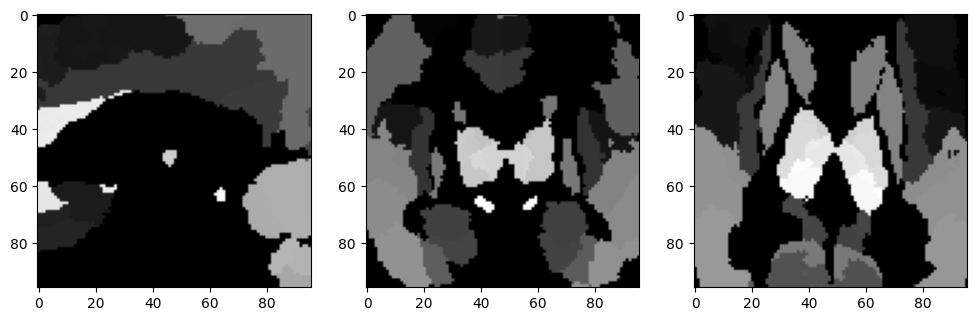

In [16]:
fig, ax = plt.subplots(1,3, figsize = (12, 6))
ax[0].imshow(atlas[:,:,atlas.shape[2]//2], cmap='gray')
ax[1].imshow(atlas[:,atlas.shape[1]//2, :], cmap='gray')
ax[2].imshow(atlas[atlas.shape[0]//2], cmap='gray')

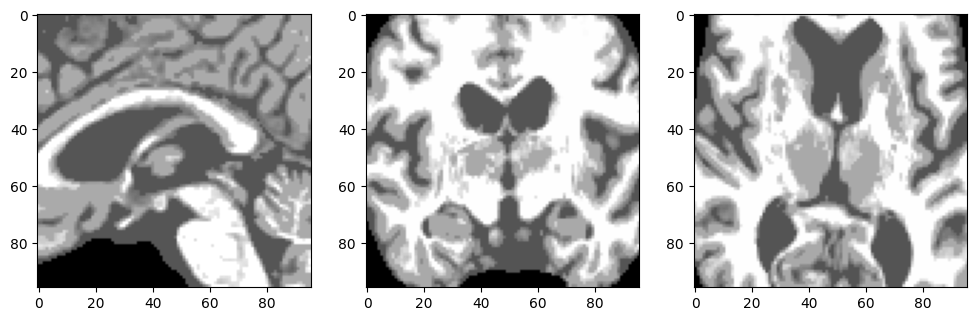

In [17]:
fig, ax = plt.subplots(1,3, figsize = (12, 6))
ax[0].imshow(img[:,:,img.shape[2]//2], cmap='gray')
ax[1].imshow(img[:,img.shape[1]//2, :], cmap='gray')
ax[2].imshow(img[img.shape[0]//2], cmap='gray')


# Dataset

In [18]:
img_path_train, img_path_val, img_path_test = data_train['Links'].to_numpy(), data_val['Links'].to_numpy(), data_test['Links'].to_numpy()
label_train, label_val, label_test = data_train['Group'].to_numpy(), data_val['Group'].to_numpy(), data_test['Group'].to_numpy()
sex_train, sex_val, sex_test = data_train['Sex'].to_numpy(), data_val['Sex'].to_numpy(), data_test['Sex'].to_numpy()
age_train, age_val, age_test = data_train['Age'].to_numpy(), data_val['Age'].to_numpy(), data_test['Age'].to_numpy()
label_to_index = dict((name, index) for index, name in enumerate(np.unique(label_train)))
index_to_label = dict((index, name) for index, name in enumerate(np.unique(label_train)))
sex_to_index = dict((name, index) for index, name in enumerate(np.unique(sex_train)))
index_to_sex = dict((index, name) for index, name in enumerate(np.unique(sex_train)))

In [19]:
label_to_index, index_to_label

({'AD': 0, 'CN': 1}, {0: 'AD', 1: 'CN'})

In [20]:
sex_train = [sex_to_index[l] for l in sex_train]
sex_train = np.array(sex_train).reshape((-1, 1))
sex_val = [sex_to_index[l] for l in sex_val]
sex_val = np.array(sex_val).reshape((-1, 1))
sex_test = [sex_to_index[l] for l in sex_test]
sex_test = np.array(sex_test).reshape((-1, 1))

In [21]:
label_age_train = []
label_age_val = []
label_age_test = []

for idx, item in enumerate(age_train):
    if(item <= 70):
        label_age_train.append(0)
    elif(item <= 80):
        label_age_train.append(1)
    else:
        label_age_train.append(2)
    
for idx, item in enumerate(age_val):
    if(item <= 70):
        label_age_val.append(0)
    elif(item <= 80):
        label_age_val.append(1)
    else:
        label_age_val.append(2)

for idx, item in enumerate(age_test):
    if(item <= 70):
        label_age_test.append(0)
    elif(item <= 80):
        label_age_test.append(1)
    else:
        label_age_test.append(2)

In [22]:
label_train = [label_to_index[l] for l in label_train]
label_train = np.array(label_train).reshape((-1, 1))
label_val = [label_to_index[l] for l in label_val]
label_val = np.array(label_val).reshape((-1, 1))
label_test = [label_to_index[l] for l in label_test]
label_test = np.array(label_test).reshape((-1, 1))

In [23]:
# the dataset objects we prepared for you
dataset_train = tf.data.Dataset.from_tensor_slices((np.array(img_path_train), label_train))
dataset_train = dataset_train.map(wrapper_val, 
                      num_parallel_calls = tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_train = dataset_train.shuffle(BUFFER_SIZE)

dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


dataset_val = tf.data.Dataset.from_tensor_slices((np.array(img_path_val), label_val))
dataset_val = dataset_val.map(wrapper_val, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((np.array(img_path_test), label_test))
dataset_test = dataset_test.map(wrapper_val, num_parallel_calls=tf.data.experimental.AUTOTUNE).map(_fixup_shape)
dataset_test = dataset_test.batch(BATCH_SIZE, drop_remainder=True)

# Model

In [24]:
def _bn_relu(input):
    """
    Helper to build a BN -> relu block (by @raghakot).
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)

def _conv_bn_relu3D(**conv_params):
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        conv = Conv3D(
            filters=filters, 
            kernel_size=kernel_size,
            strides=strides, 
            kernel_initializer=kernel_initializer,
            padding=padding,
            kernel_regularizer=kernel_regularizer
            )(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv3d(**conv_params):
    """
    Helper to build a  BN -> relu -> conv3d block.
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv3D(
                   filters=filters, 
                   kernel_size=kernel_size,
                   strides=strides, 
                   kernel_initializer=kernel_initializer,
                   padding=padding,
                   kernel_regularizer=kernel_regularizer
                   )(activation)
    return f


def _shortcut3d(input, residual):
    """
    3D shortcut to match input and residual and merges them with "sum".
    """
    stride_dim1 = ceil(input.shape[DIM1_AXIS] \
        / residual.shape[DIM1_AXIS])
    stride_dim2 = ceil(input.shape[DIM2_AXIS] \
        / residual.shape[DIM2_AXIS])
    stride_dim3 = ceil(input.shape[DIM3_AXIS] \
        / residual.shape[DIM3_AXIS])
    equal_channels = residual.shape[CHANNEL_AXIS] \
        == input.shape[CHANNEL_AXIS]

    shortcut = input
    if stride_dim1 > 1 or stride_dim2 > 1 or stride_dim3 > 1 or not equal_channels:
        shortcut = Conv3D(
            filters=residual.shape[CHANNEL_AXIS],
            kernel_size=(1, 1, 1),
            strides=(stride_dim1, stride_dim2, stride_dim3),
            kernel_initializer="he_normal", 
            padding="valid",
            kernel_regularizer=l2(1e-4)
            )(input)
    return add([shortcut, residual])


def _residual_block3d(block_function, filters, kernel_regularizer, repetitions,
                      is_first_layer=False):
    def f(input):
        for i in range(repetitions):
            strides = (1, 1, 1)
            if i == 0 and not is_first_layer:
                strides = (2, 2, 2)
            input = block_function(
                filters=filters, 
                strides=strides,
                kernel_regularizer=kernel_regularizer,
                is_first_block_of_first_layer=(is_first_layer and i == 0)
                )(input)
        return input

    return f


def basic_block(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
                is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv3D(
                filters=filters, 
                kernel_size=(3, 3, 3),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv1 = _bn_relu_conv3d(
                filters=filters,
                kernel_size=(3, 3, 3),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        residual = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv1)
        return _shortcut3d(input, residual)

    return f


def bottleneck(filters, strides=(1, 1, 1), kernel_regularizer=l2(1e-4),
               is_first_block_of_first_layer=False):
    """
    Basic 3 X 3 X 3 convolution blocks. 
    Extended from raghakot's 2D impl.
    """
    def f(input):
        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv3D(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides, 
                padding="same",
                kernel_initializer="he_normal",
                kernel_regularizer=kernel_regularizer
                )(input)
        else:
            conv_1_1 = _bn_relu_conv3d(
                filters=filters, 
                kernel_size=(1, 1, 1),
                strides=strides,
                kernel_regularizer=kernel_regularizer
                )(input)
        conv_3_3 = _bn_relu_conv3d(
            filters=filters, 
            kernel_size=(3, 3, 3),
            kernel_regularizer=kernel_regularizer
            )(conv_1_1)
        residual = _bn_relu_conv3d(
            filters=filters * 4, 
            kernel_size=(1, 1, 1),
            kernel_regularizer=kernel_regularizer
            )(conv_3_3)
        return _shortcut3d(input, residual)
    return f

def _handle_data_format():
    global DIM1_AXIS
    global DIM2_AXIS
    global DIM3_AXIS
    global CHANNEL_AXIS
    if K.image_data_format() == 'channels_last':
        DIM1_AXIS = 1
        DIM2_AXIS = 2
        DIM3_AXIS = 3
        CHANNEL_AXIS = 4
    else:
        CHANNEL_AXIS = 1
        DIM1_AXIS = 2
        DIM2_AXIS = 3
        DIM3_AXIS = 4

def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier

In [25]:
class Resnet3DBuilder(object):
    """
    ResNet3D.
    """

    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions, reg_factor):
        """
        Instantiate a vanilla ResNet3D keras model.
        # Arguments
            input_shape: Tuple of input shape in the format
            (conv_dim1, conv_dim2, conv_dim3, channels) if dim_ordering='tf'
            (filter, conv_dim1, conv_dim2, conv_dim3) if dim_ordering='th'
            num_outputs: The number of outputs at the final softmax layer
            block_fn: Unit block to use {'basic_block', 'bottlenack_block'}
            repetitions: Repetitions of unit blocks
        # Returns
            model: a 3D ResNet model that takes a 5D tensor (volumetric images
            in batch) as input and returns a 1D vector (prediction) as output.
        """
        _handle_data_format()
        if len(input_shape) != 4:
            raise ValueError(
                     "Input shape should be a tuple "
                     "(conv_dim1, conv_dim2, conv_dim3, channels) "
                     "for tensorflow as backend or "
                     "(channels, conv_dim1, conv_dim2, conv_dim3) "
                     "for theano as backend"
                     )

        block_fn = _get_block(block_fn)
        input = Input(shape=input_shape)
        # first conv
        conv1 = _conv_bn_relu3D(
            filters=64, 
            kernel_size=(7, 7, 7),
            strides=(2, 2, 2),
            kernel_regularizer=l2(reg_factor)
            )(input)
        pool1 = MaxPooling3D(
            pool_size=(3, 3, 3), 
            strides=(2, 2, 2),
            padding="same")(conv1)

        # repeat blocks
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block3d(
                block_fn, 
                filters=filters,
                kernel_regularizer=l2(reg_factor),
                repetitions=r, 
                is_first_layer=(i == 0)
                )(block)
            filters *= 2

        # last activation
        block_output = _bn_relu(block)

        # average poll and classification
        pool2 = AveragePooling3D(
            pool_size=(block.shape[DIM1_AXIS],
                       block.shape[DIM2_AXIS],
                       block.shape[DIM3_AXIS]),
            strides=(1, 1, 1)
            )(block_output)
        flatten1 = Flatten()(pool2)
        if num_outputs > 1:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="softmax",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)
        else:
            dense = Dense(
                units=num_outputs,
                kernel_initializer="he_normal",
                activation="sigmoid",
                kernel_regularizer=l2(reg_factor)
                )(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs, reg_factor=1e-4):
        """
        Build resnet 18.
        """
        return Resnet3DBuilder.build(input_shape, num_outputs, basic_block,
                                     [2, 2, 2, 2], reg_factor=reg_factor)

In [26]:
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_DEPTH, CHANNELS)
builder = Resnet3DBuilder()
model = builder.build_resnet_18(input_shape, 2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 96,  0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 48, 48, 48, 6 22016       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 48, 48, 48, 6 256         conv3d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 48, 48, 48, 6 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Training

In [27]:
initial_learning_rate = 0.0001

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=Adam(learning_rate=initial_learning_rate, epsilon=1e-8),
    metrics=["accuracy"],
)

# # Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "./model3D/baseline/baseline_fold_" + fold +"_1.h5", save_best_only=True, monitor='val_accuracy', mode='max'
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)
# 
# # # Train the model, doing validation at the end of each epoch
# epochs = 30
# history = model.fit(
#     dataset_train,
#     validation_data=dataset_val, 
#     class_weight=class_weights,
#     epochs=epochs,
#     shuffle=True,
#     verbose=1,
#     callbacks=[checkpoint_cb],
# )

ModuleNotFoundError: No module named 'keras'

# Evaluate

In [28]:
model.load_weights("D:/Lab/model/notebook/3D/model3D/baseline/baseline_fold_" + fold +"_1.h5")

In [47]:
model.evaluate(dataset_test)

21/21 [==============================] - 29s 1s/step - loss: 1.8072 - accuracy: 0.8143


[1.8072431087493896, 0.8142856955528259]

# Get ref image

In [110]:
dr = 'D:\\Lab\\ig\\all_subject_AD\\'
path = 'D:\\Lab\\ig\\all_subject_AD\\baseline_'
target = 0
target_label = 'CN'


if target_label == 'CN':
    target = 1
else:
    target = 0

In [102]:
i = 0
count = 0    
gender_anchor = 'F'
with open(path + str(target_label) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'w') as f:
    for idx in tqdm(range(len(data_train['Links']))):
        filename = data_train['Links'][idx]
        dirname = filename.split('\\')
        imagename = dirname[-1]
        sid = dirname[3]
        label = data_train['Group'][idx]
        gender = data_train['Sex'][idx]
        age = label_age_train[idx]
        if gender != gender_anchor or (sid not in target_bs):
            continue
        img, baseline, atlas = apply_mask(filename)
        bs = tf.expand_dims(img, axis = 0)
        y_pred = model.predict(bs)[0]
    
        if label == target_label and np.argmax(y_pred) == target:
            if not os.path.exists(dr + imagename):
                shutil.copyfile(filename, dr + imagename)
            f.write(filename)
            f.write("\n")

100%|█████████████████████████████████████████████████████████████████████████████| 1040/1040 [00:01<00:00, 633.80it/s]


In [78]:
# for finding subject 
count = 0
target = 0
image_set = set()
sid_set_dict = dict()
    
i = 0
for idx in tqdm(range(len(data_test['Links']))):
    filename = data_test['Links'][idx]
    dirname = filename.split('\\')
    imagename = dirname[-1][2:]
    sid = dirname[3]
    label_anchor = data_test['Group'][idx]
    if label_anchor == 'AD':
        target = 0
    else:
        target = 1
    gender_anchor = data_test['Sex'][idx]
    age_anchor = label_age_test[idx]
    img, baseline, atlas = apply_mask(filename)
    bs = tf.expand_dims(img, axis = 0)
    y_pred = model.predict(bs)[0]
    
    if np.argmax(y_pred) == target and y_pred[target] >= 0.7:
        image_set.add(imagename)
        temp_dir = os.path.join(dr, imagename)
        if not os.path.exists(temp_dir):
            os.mkdir(temp_dir)
        shutil.copyfile('\\'.join(dirname[:-1]) + '\\iy_' + imagename, temp_dir + '\\iy_original.nii')
        target_y = '\\'.join(dirname[:-1]) + '\\y_' + imagename
        target_age = age_test[idx]
        shutil.copyfile(filename, temp_dir + '\\original.nii')
        shutil.copyfile(target_y, temp_dir + '\\y_original.nii')
        sid_set_dict[imagename] = [gender_anchor, target_age, target, filename]

  0%|          | 0/214 [00:00<?, ?it/s]

In [116]:
# for finding subject 
count = 0
target = 0
image_set = set()
sid_set_dict = dict()
    
i = 0
for idx in tqdm(range(len(data_test['Links']))):
    filename = data_test['Links'][idx]
    dirname = filename.split('\\')
    imagename = dirname[-1][2:]
    image = imagename[:-4]
    sid = dirname[3]
    label_anchor = data_test['Group'][idx]
    if label_anchor == 'CN':
        continue
    target = 0
    gender_anchor = data_test['Sex'][idx]
    age_anchor = label_age_test[idx]
    img, baseline, atlas = apply_mask(filename)
    bs = tf.expand_dims(img, axis = 0)
    y_pred = model.predict(bs)[0]
    
    if np.argmax(y_pred) == target and y_pred[target] >= 0.7:
        image_set.add(image)
        temp_dir = os.path.join(dr, image)
        if not os.path.exists(temp_dir):
            os.mkdir(temp_dir)
        shutil.copyfile('\\'.join(dirname[:-1]) + '\\iy_' + imagename, temp_dir + '\\iy_original.nii')
        target_y = '\\'.join(dirname[:-1]) + '\\y_' + imagename
        target_age = age_test[idx]
        shutil.copyfile(filename, temp_dir + '\\original.nii')
        shutil.copyfile(target_y, temp_dir + '\\y_original.nii')
        sid_set_dict[image] = [gender_anchor, target_age, target, filename]

  0%|          | 0/214 [00:00<?, ?it/s]

In [119]:
with open(dr + '\\list_subject.txt', 'w') as f:
    for each in image_set:
        f.write(each)
        f.write('\n')

In [120]:
header = ["Name", "Gender", "Age", "Label", "Filename"]
with open(dr + 'sid_details.csv', 'w') as file:
    writer = csv.writer(file, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header)
    
    for sid, det in sid_set_dict.items():
        writer.writerow([sid, det[0], det[1], det[2], det[3]])

In [41]:
sid_set = set()
with open(dr + 'list_subject.txt', 'r') as f:
    for each in f:
        sid_set.add(each)

In [42]:
sid_df = pd.read_csv(dr + '\\sid_details.csv')
sid_df.head()

,Name,Gender,Age,Label,Filename
0,002_S_1280,F,71,1,D:\Lab\ADNI\002_S_1280\MPR__GradWarp__B1_Corre...
1,067_S_0059,F,71,1,D:\Lab\ADNI\067_S_0059\MPR__GradWarp__B1_Corre...
2,082_S_0304,F,71,1,D:\Lab\ADNI\082_S_0304\MPR__GradWarp__B1_Corre...
3,011_S_0021,F,73,1,D:\Lab\ADNI\011_S_0021\MPR__GradWarp__B1_Corre...
4,094_S_1267,M,73,1,D:\Lab\ADNI\094_S_1267\MPR__GradWarp__B1_Corre...


In [47]:
dr = 'D:\\Lab\\ig\\age_70\\'
path = 'D:\\Lab\\ig\\age_70\\baseline_'
target = 0
target_label = 'CN'


if target_label == 'CN':
    target = 1
else:
    target = 0
    
sid_set = set()
with open(dr + 'list_subject.txt', 'r') as f:
    for each in f:
        sid_set.add(each)
sid_df = pd.read_csv(dr + '\\sid_details.csv')
sid_df.head()
sid_set_dict = {}
for idx in range(sid_df.shape[0]):
    sid_set_dict[sid_df['Name'][idx]] = [sid_df['Gender'][idx], sid_df['Age'][idx], sid_df['Label'][idx], sid_df['Filename'][idx]]

In [103]:
header = ["Name", "Gender", "Age", "Label", "Filename"]
with open(dr + 'sid_details.csv', 'w') as file:
    writer = csv.writer(file, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(header)
    
    for sid, det in sid_set_dict.items():
        writer.writerow([sid, det[0], det[1], det[2], det[3]])

In [309]:
nib.load(dr + 'y_baseline_2.nii').get_fdata().shape

(113, 137, 113, 1, 3)

In [ ]:
baseline = apply_mask_one(baseline_filename)
bs = tf.expand_dims(baseline, axis = 0)
y_pred = model.predict(bs)[0]
y_pred

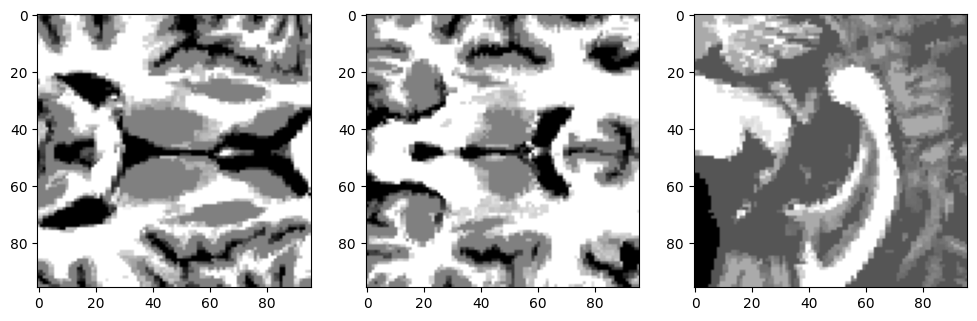

In [2324]:
fig, ax = plt.subplots(1,3, figsize = (12, 6))
ax[0].imshow(baseline[:,:,baseline.shape[2]//2], cmap='gray')
ax[1].imshow(baseline[:,baseline.shape[1]//2, :], cmap='gray')
ax[2].imshow(baseline[baseline.shape[0]//2], cmap='gray')

In [369]:
target, gender_anchor, target_label, age_anchor

(0, 'M', 'AD', 0)

# Get a

In [82]:
target_label = 'CN'
if target_label == 'CN':
    target = 1
else:
    target = 0
    
for sex in ['F', 'M']:
    candidate = []
    candidate_to_image = []
    image_to_age = []
    i = 0
    for idx in tqdm(range(len(data_train['Links']))):
        filename = data_train['Links'][idx]
        dirname = filename.split('\\')
        imagename = dirname[-1][2:]
        sid = dirname[3]
        label_anchor = data_train['Group'][idx]
        gender_anchor = data_train['Sex'][idx]
        age_anchor = age_train[idx]
        img, baseline, atlas = apply_mask(filename)
        bs = tf.expand_dims(img, axis = 0)
        y_pred = model.predict(bs)[0]

        if label_anchor == target_label and gender_anchor == sex and np.argmax(y_pred) == target:
            target_iy = '\\'.join(dirname[:-1]) + '\\y_' + imagename
            sitk_img = sitk.ReadImage(target_iy)
            m = sitk.GetArrayFromImage(sitk_img)
            candidate_to_image.append(imagename)
            image_to_age.append(age_anchor)
            candidate.append(m)
    np.save('D:\\Lab\\ig\\data\\all_candidate_CN_' + sex + '.npy', np.stack(candidate, axis = 0))
    np.save('D:\\Lab\\ig\\data\\all_image_CN_' + sex + '.npy', np.stack(candidate_to_image, axis = 0))
    np.save('D:\\Lab\\ig\\data\\all_age_CN_' + sex + '.npy', np.stack(image_to_age, axis = 0))

  0%|          | 0/1040 [00:00<?, ?it/s]

  0%|          | 0/1040 [00:00<?, ?it/s]

# Get nearest ref image + create ref image list txt

In [29]:
dr = 'D:\\Lab\\ig\\all_subject_AD\\'
path = 'D:\\Lab\\ig\\all_subject_AD\\baseline_'
target = 0
target_label = 'CN'


if target_label == 'CN':
    target = 1
else:
    target = 0
    
sid_set = set()
with open(dr + 'list_subject.txt', 'r') as f:
    for each in f:
        each = each.strip('\n')
        sid_set.add(each)
sid_df = pd.read_csv(dr + '\\sid_details.csv')
sid_df.head()
sid_set_dict = {}
for idx in range(sid_df.shape[0]):
    sid_set_dict[sid_df['Name'][idx]] = [sid_df['Gender'][idx], sid_df['Age'][idx], sid_df['Label'][idx], sid_df['Filename'][idx]]

In [30]:
cur_target_baseline = 'CN'

if cur_target_baseline == 'AD':
    cur_target = 1
else:
    cur_target = 0
    
with open(dr + 'all_baseline.txt', 'w') as f:
    for cur_target_gender in ['F', 'M']:
        candidate = np.load('D:\\Lab\\ig\\data\\all_candidate_' + cur_target_baseline + '_' + cur_target_gender + '.npy')
        candidate_to_sid = np.load('D:\\Lab\\ig\\data\\all_image_'+ cur_target_baseline + '_' + cur_target_gender + '.npy')
        sid_to_age = np.load('D:\\Lab\\ig\\data\\all_age_'+ cur_target_baseline + '_' + cur_target_gender +  '.npy')

        tr_age = spatial.KDTree(sid_to_age.reshape(-1, 1))
        relative_target = 0
        temp_sbj_list = []
        
        for each in tqdm(sid_set):
            temp_dir = dr + each
            if sid_set_dict[each][0] == cur_target_gender and sid_set_dict[each][2] == cur_target:
                temp_sbj_list.append(each)
                target_age = sid_set_dict[each][1] + relative_target
                if target_age not in sid_to_age:
                    print(each, sid_set_dict[each][1])

                    dd, ii = tr_age.query([target_age], k = 1)
                    print(dd, sid_to_age[ii])
                    target_age = sid_to_age[ii]

                # find nearest baseline
                new_dict = dict()
                for c, a in zip(candidate_to_sid, sid_to_age):
                    if new_dict.get(c, []) == []:
                        new_dict[c] = []
                    new_dict[c].append(a)

                new_cand = [i.ravel() for idx, i in enumerate(candidate) if target_age -5 <= sid_to_age[idx] <= target_age + 5]
                idx = np.where((sid_to_age <= target_age + 5) & (sid_to_age >= target - 5))
                new_cand_imagename = candidate_to_sid[idx]
                new_cand = np.stack(new_cand, axis = 0)

                tr = spatial.KDTree(new_cand)
                sitk_img = sitk.ReadImage(temp_dir + '\\y_original.nii')
                y_sbj = sitk.GetArrayFromImage(sitk_img)
                dd, ii = tr.query([y_sbj.ravel()], k = 5)
                target_bs = np.array(new_cand_imagename)[ii[0][:new_cand.shape[0]]]

                # create baseline txt at each of the directory
                with open(temp_dir + '\\baseline.txt', 'w') as f_baseline:
                    for idx in tqdm(range(len(data_train['Links']))):
                        filename = data_train['Links'][idx]
                        dirname = filename.split('\\')
                        imagename = dirname[-1]
                        baseline_sid = dirname[3]
                        label = data_train['Group'][idx]
                        gender = data_train['Sex'][idx]
                        age = label_age_train[idx]
                        if imagename[2:] not in target_bs:
                            continue

                        img, baseline, atlas = apply_mask(filename)
                        bs = tf.expand_dims(img, axis = 0)
                        y_pred = model.predict(bs)[0]

                        if label == cur_target_baseline and np.argmax(y_pred) == (1 - cur_target):
                            if not os.path.exists(dr + '\\baseline\\' + imagename):
                                shutil.copyfile(filename, dr + '\\baseline\\' + imagename)
                                f.write(filename)
                                f.write("\n")
                            f_baseline.write(filename)
                            f_baseline.write("\n")

  0%|          | 0/66 [00:00<?, ?it/s]

KeyboardInterrupt: 

# IG + Proposed

In [23]:
cur_target_baseline = 'CN'
cur_target_gender = 'F'
if cur_target_gender == 'F':
    cur_baseline_gender = 'M'
else:
    cur_baseline_gender = 'F'
    
if cur_target_baseline == 'AD':
    cur_target = 1
else:
    cur_target = 0

candidate = np.load('D:\\Lab\\ig\\data\\candidate_' + cur_target_baseline + '_' + cur_baseline_gender +'.npy')
candidate_to_sid = np.load('D:\\Lab\\ig\\data\\sid_'+ cur_target_baseline + '_' + cur_baseline_gender +'.npy')
sid_to_age = np.load('D:\\Lab\\ig\\data\\age_'+ cur_target_baseline + '_' + cur_baseline_gender +'.npy')

tr_age = spatial.KDTree(sid_to_age.reshape(-1, 1))
cur_target_age = 60
relative_target = -10
temp_sbj_list = []

In [24]:
m_steps= 800
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [25]:
def edited(baseline,  n=0.5):
    noise = np.random.normal(0, n, baseline.shape).astype(np.float32)
    # images = alphas_x * input_x
    return baseline + noise

In [26]:
def interpolated_image(baseline, image, alphas, n=0.00):
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(tf.cast(baseline, tf.float32), axis = 0)
    input_x = tf.expand_dims(image, axis = 0)
    delta = input_x - baseline_x
    images = baseline_x + alphas_x * delta
    # images =  alphas_x * input_x
    noise = np.random.normal(0, n, images.shape).astype(np.float32)
    # images = alphas_x * input_x
    return images + noise

In [27]:
def compute_gradients(images, target):
    with tf.GradientTape() as tape:
        tape.watch(images)
        logits = model(images)
        probs = logits[:, target]
    return tape.gradient(probs, images)

In [29]:
def integral_approximation(gradients):
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
    integrated_gradients = tf.math.reduce_mean(grads, axis = 0)
    return integrated_gradients

In [99]:
sbj_filename = 'D:\\Lab\\ADNI\\005_S_0814\\MPR__GradWarp__B1_Correction\\2006-08-30_09_32_32.0\\I74592\\mri\\p0ADNI_005_S_0814_MR_MPR__GradWarp__B1_Correction_Br_20070923123156274_S18390_I74592.nii'

In [100]:
img = apply_mask_one(sbj_filename)
y_pred_img = model.predict(tf.expand_dims(img , axis = 0))
print(y_pred_img)

[[9.9997723e-01 2.2778417e-05]]


In [114]:
with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
    for filename in f.readlines():
        filename = filename.strip('\n')
        imagename = filename.split('\\')[-1]
        baseline_filename = 'D:\\Lab\\ig\\pairs_diff\\' + 'ww' + imagename
        # baseline = apply_mask_one(baseline_filename)
        img, baseline, atlas = apply_mask_baseline(sbj_filename, baseline_filename)
        # baseline = baseline / 1.5
        baseline = edited(baseline, n = 0.5)
        y_pred_img = model.predict(tf.expand_dims(baseline , axis = 0))
        print(y_pred_img)
        break

NameError: name 'new_target_age' is not defined

In [478]:
diff_img = baseline

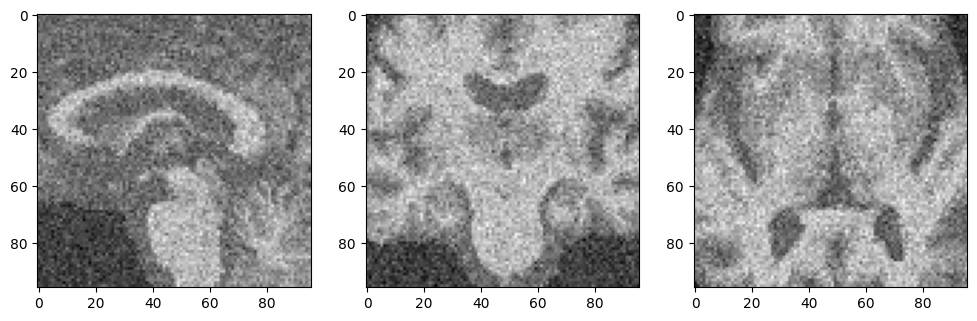

In [479]:
fig, ax = plt.subplots(1,3, figsize = (12, 6))
ax[0].imshow(diff_img[:,:,diff_img.shape[2]//2], cmap='gray')
ax[1].imshow(diff_img[:,diff_img.shape[1]//2, :], cmap='gray')
ax[2].imshow(diff_img[diff_img.shape[0]//2], cmap='gray')

In [79]:
dr = 'D:\\Lab\\ig\\all_subject_AD\\'
path = 'D:\\Lab\\ig\\all_subject_AD\\baseline_'
target = 0
target_label = 'CN'


if target_label == 'CN':
    target = 1
else:
    target = 0
    
sid_set = set()
with open(dr + 'list_subject.txt', 'r') as f:
    for each in f:
        each = each.strip('\n')
        sid_set.add(each)
sid_df = pd.read_csv(dr + '\\sid_details.csv')
sid_df.head()
sid_set_dict = {}
for idx in range(sid_df.shape[0]):
    sid_set_dict[sid_df['Name'][idx]] = [sid_df['Gender'][idx], sid_df['Age'][idx], sid_df['Label'][idx], sid_df['Filename'][idx]]

In [97]:
# all subject
target_baseline = 1
target_sbj = 0
final_res = None

if target_baseline == 0:
    label_baseline = 'AD'
else:
    label_baseline = 'CN'
filename3 = 'D:\\Lab\\ig\\individual\\aal3_AD_AD.csv'
df_aal = pd.read_csv(filename3, delimiter=',')

aal_dict = dict()

for key, val in zip(df_aal['ROIid'], df_aal['ROIname']):
    if 95 <= key <= 120:
        continue
    aal_dict[key] = val
# with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
with open(dr + '\\list_subject.txt', 'r') as f_sbj:
    for sid in tqdm(f_sbj):
        sid = sid.strip('\n')
        temp_dir = dr + sid
        sbj_filename = sid_set_dict[sid][3]
        # if os.path.exists(temp_dir + '\\output.nii'):
        #     continue
        
        target_baseline = 1 - sid_set_dict[sid][2]
        target_sbj = sid_set_dict[sid][2]
        if target_baseline == 0:
            label_baseline = 'AD'
        else:
            label_baseline = 'CN'
        count = 0
        with open(temp_dir + '\\baseline.txt', 'r') as f:
            for filename in f.readlines():
                filename = filename.strip('\n')
                imagename = filename.split('\\')[-1]
                baseline_filename = dr + '\\baseline\\ww_' + sid + '_w' + imagename
                img, baseline, atlas = apply_mask_baseline(sbj_filename, baseline_filename)
#                 if label_baseline == 'AD':
#                     baseline = edited(baseline, n = 0.5)
#                 else:
#                     baseline = baseline / 1.5
#                 y_pred_bs = model.predict(tf.expand_dims(baseline , axis = 0))
#                 y_pred_img = model.predict(tf.expand_dims(img , axis = 0))
#                 if np.argmax(y_pred_img) != target_sbj or np.argmax(y_pred_bs) != target_baseline or y_pred_bs[0][target_baseline] < 0.7:
#                     continue

#                 total = None
#                 for i in range(0, m_steps, 20):
#                     interpolated_img = interpolated_image(
#                     baseline=baseline,
#                     image=img,
#                     alphas=alphas[i : i + 20])

#                     path_gradient = compute_gradients(interpolated_img,  target_sbj)
#                     mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

#                     if total == None:
#                         total = mean
#                     else:
#                         total = tf.concat([total, mean], axis = 0)
#                 total = tf.math.reduce_mean(total, axis = 0)
#                 ig = (img - baseline) * total.numpy()
#                 result = abs(ig)
#                 # result[result < 0] = 0

#                 result = (result - result.min()) / (result.max() - result.min())
#                 q1, q2, q3 = np.percentile(result, [25, 50, 75])
#                 iqr = q3 - q1
#                 maximum = q3 + 10 * iqr
#                 temp2 = copy.deepcopy(result)
#                 temp2[result < maximum] = 0
#                 blurred3 = cv2.medianBlur(temp2,1)
#                 blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())

#                 if count == 0:
#                     final_res = blurred3[np.newaxis, :]
#                 else: 
#                     final_res = np.concatenate((blurred3[np.newaxis, :], final_res), axis = 0)
#                 count += 1
                
#             res = np.mean(final_res, axis=0)
            img = apply_mask_img(sbj_filename)
            image = nib.load(sbj_filename)
            print('here')
            # ni_img = nib.Nifti1Image(res, image.affine)
            # nib.save(ni_img, temp_dir + '\\output.nii')
            nib.save(nib.Nifti1Image(atlas, image.affine), temp_dir + '\\atlas.nii')
            # nib.save(nib.Nifti1Image(img, image.affine), temp_dir + '\\original_resize.nii')
            
#             diff_atlas_temp2 = copy.deepcopy(atlas)
#             diff_atlas_temp2[res == 0] = 0
#             dict_val = Counter(np.ravel(diff_atlas_temp2))
#             atlas_dict_val = Counter(np.ravel(atlas))
#             new_dict_val = dict()
#             for key, val in dict_val.items():
#                 # new_dict_val[key] = val / atlas_dict_val[key]
#                 new_dict_val[key] = np.sum(res[atlas == key]) / atlas_dict_val[key]
#             sort_dict_val= sorted(new_dict_val.items(), key = lambda x: x[1], reverse=True)
            
#             list_label = []
#             list_val = []
#             for key, val in sort_dict_val:
#                 if key == 0 or 95 <= key <= 120:
#                     continue
#                 list_label.append(aal_dict[key])
#                 list_val.append(val)
#             plt.figure(figsize=(10,6))
#             plt.bar(list_label[:20], list_val[:20])
#             plt.xticks(rotation=90)
#             plt.savefig(temp_dir + '\\importance.png', dpi=400, bbox_inches='tight')
        #     break
        # break

0it [00:00, ?it/s]

here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here
here


In [93]:
temp_dir

'D:\\Lab\\ig\\all_subject_AD\\ADNI_036_S_1001_MR_MPR__GradWarp__B1_Correction_Br_20071221155504817_S43195_I85951'

In [32]:
with open(dr + '\\list_subject.txt', 'r') as f_sbj:
    with open(dr + '\\list_subject_for_average.txt', 'w') as f:
        for sid in tqdm(f_sbj):
            sid = sid.strip('\n')
            temp_dir = dr + sid
            sbj_filename = sid_set_dict[sid][3]
            f.write(temp_dir + '\\output.nii')
            f.write('\n')

0it [00:00, ?it/s]

In [67]:
print()

In [88]:
# AD subject all black
# target_baseline = 1
# target_sbj = 0
final_res = None
count = 0

# if target_baseline == 0:
#     label_baseline = 'AD'
# else:
#     label_baseline = 'CN'
# filename3 = 'D:\\Lab\\ig\\individual\\aal3_AD_AD.csv'
# df_aal = pd.read_csv(filename3, delimiter=';')

# aal_dict = dict()

# for key, val in zip(df_aal['ROIid'], df_aal['ROIname']):
#     if 95 <= key <= 120:
#         continue
#     aal_dict[key] = val
# with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
with open(dr + '\\list_subject.txt', 'r') as f_sbj:
    for sid in tqdm(f_sbj):
        
        sid = sid.strip('\n')
        temp_dir = dr + sid
        sbj_filename = sid_set_dict[sid][3]
        
        img = apply_mask_one(sbj_filename)
        baseline = np.zeros((96, 96, 96))
        y_pred_bs = model.predict(tf.expand_dims(baseline , axis = 0))
        y_pred_img = model.predict(tf.expand_dims(img , axis = 0))
        print(y_pred_img, y_pred_bs)

        total = None
        for i in range(0, m_steps, 20):
            interpolated_img = interpolated_image(
            baseline=baseline,
            image=img,
            alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  target_sbj)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        ig = (img - baseline) * total.numpy()
        result = abs(ig)
        # result[result < 0] = 0

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 10 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2,1)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())

        if count == 0:
            final_res = blurred3[np.newaxis, :]
        else: 
            final_res = np.concatenate((blurred3[np.newaxis, :], final_res), axis = 0)
                
        res = np.mean(final_res, axis=0)
        img = apply_mask_img(sbj_filename)
        image = nib.load(sbj_filename)
        ni_img = nib.Nifti1Image(res, image.affine)
        nib.save(ni_img, temp_dir + '\\output_black.nii')

#         diff_atlas_temp2 = copy.deepcopy(atlas)
#         diff_atlas_temp2[res == 0] = 0
#         dict_val = Counter(np.ravel(diff_atlas_temp2))
#         atlas_dict_val = Counter(np.ravel(atlas))
#         new_dict_val = dict()
#         for key, val in dict_val.items():
#             # new_dict_val[key] = val / atlas_dict_val[key]
#             new_dict_val[key] = np.sum(res[atlas == key]) / atlas_dict_val[key]
#         sort_dict_val= sorted(new_dict_val.items(), key = lambda x: x[1], reverse=True)

#         list_label = []
#         list_val = []
#         for key, val in sort_dict_val:
#             if key == 0 or 95 <= key <= 120:
#                 continue
#             list_label.append(aal_dict[key])
#             list_val.append(val)
#         plt.figure(figsize=(10,6))
#         plt.bar(list_label[:20], list_val[:20])
#         plt.xticks(rotation=90)
#         plt.savefig(temp_dir + '\\importance_black.png', dpi=400, bbox_inches='tight')

0it [00:00, ?it/s]

[[0.9770055  0.02299453]] [[0.02534897 0.97465104]]
[[9.994543e-01 5.456877e-04]] [[0.02534897 0.97465104]]
[[9.9999988e-01 1.2241746e-07]] [[0.02534897 0.97465104]]
[[0.9902202  0.00977977]] [[0.02534897 0.97465104]]
[[1.0000000e+00 1.1656469e-08]] [[0.02534897 0.97465104]]
[[1.00000e+00 6.06794e-10]] [[0.02534897 0.97465104]]
[[0.8485545  0.15144546]] [[0.02534897 0.97465104]]
[[0.9639933  0.03600668]] [[0.02534897 0.97465104]]
[[9.9999034e-01 9.6843878e-06]] [[0.02534897 0.97465104]]
[[0.99672616 0.00327382]] [[0.02534897 0.97465104]]
[[0.72768724 0.2723128 ]] [[0.02534897 0.97465104]]
[[1.000000e+00 3.424139e-08]] [[0.02534897 0.97465104]]
[[1.0000000e+00 7.5334317e-10]] [[0.02534897 0.97465104]]
[[0.997815   0.00218502]] [[0.02534897 0.97465104]]
[[9.9999964e-01 3.3667317e-07]] [[0.02534897 0.97465104]]
[[0.99873513 0.00126488]] [[0.02534897 0.97465104]]
[[9.9997723e-01 2.2778417e-05]] [[0.02534897 0.97465104]]
[[9.9994969e-01 5.0359904e-05]] [[0.02534897 0.97465104]]
[[1.0000000e

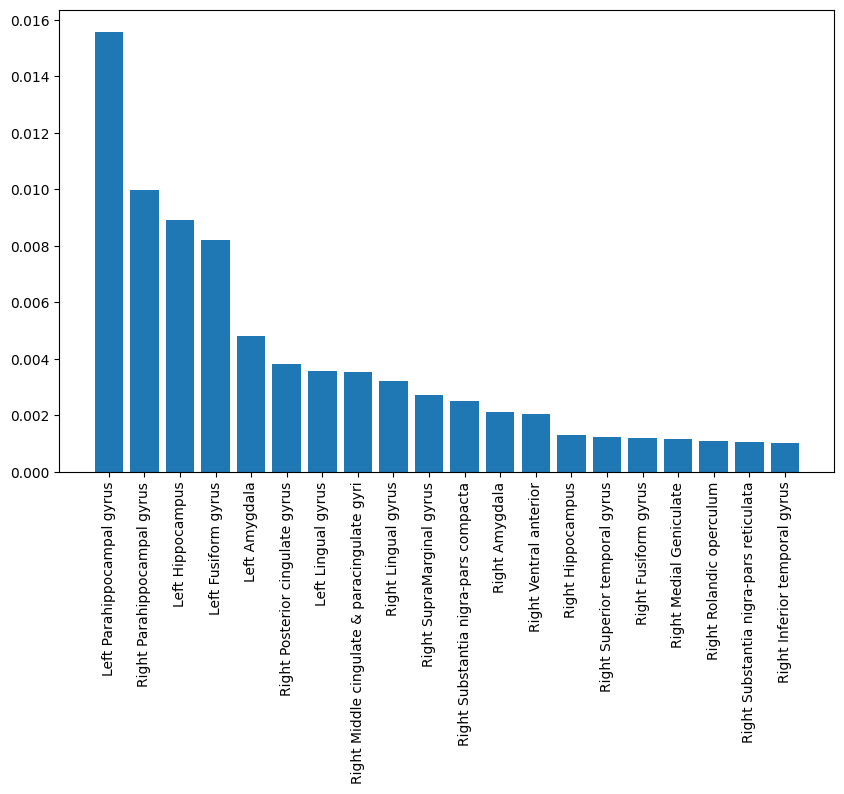

In [123]:
diff_atlas_temp2 = copy.deepcopy(atlas)
diff_atlas_temp2[res == 0] = 0
dict_val = Counter(np.ravel(diff_atlas_temp2))
atlas_dict_val = Counter(np.ravel(atlas))
new_dict_val = dict()
for key, val in dict_val.items():
    # new_dict_val[key] = val / atlas_dict_val[key]
    new_dict_val[key] = np.sum(res[atlas == key]) / atlas_dict_val[key]
sort_dict_val= sorted(new_dict_val.items(), key = lambda x: x[1], reverse=True)

list_label = []
list_val = []
for key, val in sort_dict_val:
    if key == 0 or 95 <= key <= 120:
        continue
    list_label.append(aal_dict[key])
    list_val.append(val)
plt.figure(figsize=(10,6))
plt.bar(list_label[:20], list_val[:20])
plt.xticks(rotation=90)
plt.savefig('D:\\Lab\\ig\\age_70\\importance.png', dpi=400, bbox_inches='tight')

In [211]:
target_baseline = 1
target_sbj = 0
final_res = None
count = 0

if target_baseline == 0:
    label_baseline = 'AD'
else:
    label_baseline = 'CN'
    
img = apply_mask_one(sbj_filename)
baseline = np.zeros((96, 96, 96))
y_pred_bs = model.predict(tf.expand_dims(baseline , axis = 0))
y_pred_img = model.predict(tf.expand_dims(img , axis = 0))
print(y_pred_img, y_pred_bs)
    
total = None
for i in tqdm(range(0, m_steps, 20)):
    interpolated_img = interpolated_image(
    baseline=baseline,
    image=img,
    alphas=alphas[i : i + 20])

    path_gradient = compute_gradients(interpolated_img,  target_sbj)
    mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

    if total == None:
        total = mean
    else:
        total = tf.concat([total, mean], axis = 0)
total = tf.math.reduce_mean(total, axis = 0)
ig = (img - baseline) * total.numpy()
result = abs(ig)
# result[result < 0] = 0

result = (result - result.min()) / (result.max() - result.min())
q1, q2, q3 = np.percentile(result, [25, 50, 75])
iqr = q3 - q1
maximum = q3 + 10 * iqr
temp2 = copy.deepcopy(result)
temp2[result < maximum] = 0
blurred3 = cv2.medianBlur(temp2,1)
blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())

if count == 0:
    final_res = blurred3[np.newaxis, :]
else: 
    final_res = np.concatenate((blurred3[np.newaxis, :], final_res), axis = 0)

res = np.mean(final_res, axis=0)
img = apply_mask_img(sbj_filename)
image = nib.load(sbj_filename)
ni_img = nib.Nifti1Image(res, image.affine)
nib.save(ni_img, 'D:\\Lab\\ig\\pairs_diff\\baseline\\output_CN_AD_F.nii')
nib.save(nib.Nifti1Image(img, image.affine), 'D:\\Lab\\ig\\pairs_diff\\baseline\\original_AD_F.nii')

[[0.9961803  0.00381976]] [[0.02534021 0.97465974]]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:19<00:00,  2.00s/it]


In [104]:
target_baseline = 1
target_sbj = 0
final_res = None
count = 0

if target_baseline == 0:
    label_baseline = 'AD'
else:
    label_baseline = 'CN'
    
# with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
    for filename in f.readlines():
        filename = filename.strip('\n')
        imagename = filename.split('\\')[-1]
        baseline_filename = 'D:\\Lab\\ig\\pairs_diff\\' + 'ww' + imagename
        img, baseline, atlas = apply_mask_baseline(sbj_filename, baseline_filename)
        # baseline = np.zeros((96, 96, 96))
        baseline = baseline / 1.5
        # baseline = edited(baseline, n = 0.5)
        y_pred_bs = model.predict(tf.expand_dims(baseline , axis = 0))
        y_pred_img = model.predict(tf.expand_dims(img , axis = 0))
        print(y_pred_img, y_pred_bs)
        if np.argmax(y_pred_img) != target_sbj or np.argmax(y_pred_bs) != target_baseline or y_pred_bs[0][target_baseline] < 0.7:
            continue
            # if np.argmax(y_pred_bs) != target_baseline:
            #     baseline = baseline / 1.5
            #     y_pred_bs = model.predict(tf.expand_dims(baseline , axis = 0))
            #     if np.argmax(y_pred_bs) != target_baseline:
            #         continue
        
        # print(y_pred_img, y_pred_bs)
        total = None
        for i in tqdm(range(0, m_steps, 20)):
            interpolated_img = interpolated_image(
            baseline=baseline,
            image=img,
            alphas=alphas[i : i + 20])

            path_gradient = compute_gradients(interpolated_img,  target_sbj)
            mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

            if total == None:
                total = mean
            else:
                total = tf.concat([total, mean], axis = 0)
        total = tf.math.reduce_mean(total, axis = 0)
        ig = (img - baseline) * total.numpy()
        result = abs(ig)
        # result[result < 0] = 0

        result = (result - result.min()) / (result.max() - result.min())
        q1, q2, q3 = np.percentile(result, [25, 50, 75])
        iqr = q3 - q1
        maximum = q3 + 10 * iqr
        temp2 = copy.deepcopy(result)
        temp2[result < maximum] = 0
        blurred3 = cv2.medianBlur(temp2,1)
        blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        
        if count == 0:
            final_res = blurred3[np.newaxis, :]
        else: 
            final_res = np.concatenate((blurred3[np.newaxis, :], final_res), axis = 0)
        count += 1
    res = np.mean(final_res, axis=0)
    img = apply_mask_img(sbj_filename)
    image = nib.load(sbj_filename)
    ni_img = nib.Nifti1Image(res, image.affine)
    nib.save(ni_img, 'D:\\Lab\\ig\\pairs_diff\\output_CN_AD_F.nii')
    nib.save(nib.Nifti1Image(atlas, image.affine), 'D:\\Lab\\ig\\pairs_diff\\atlas_AD_F.nii')
    nib.save(nib.Nifti1Image(img, image.affine), 'D:\\Lab\\ig\\pairs_diff\\original_AD_F.nii')

[[9.9997723e-01 2.2778417e-05]] [[0.00259022 0.99740976]]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [01:07<00:00,  1.69s/it]


[[9.9997723e-01 2.2778417e-05]] [[0.00603652 0.9939634 ]]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:38<00:00,  1.05it/s]


[[9.9997723e-01 2.2778417e-05]] [[0.00500887 0.9949911 ]]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.06it/s]


[[9.9997723e-01 2.2778417e-05]] [[0.00654463 0.99345535]]


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:37<00:00,  1.06it/s]


In [119]:
result = abs(ig)
result = (result - result.min()) / (result.max() - result.min())

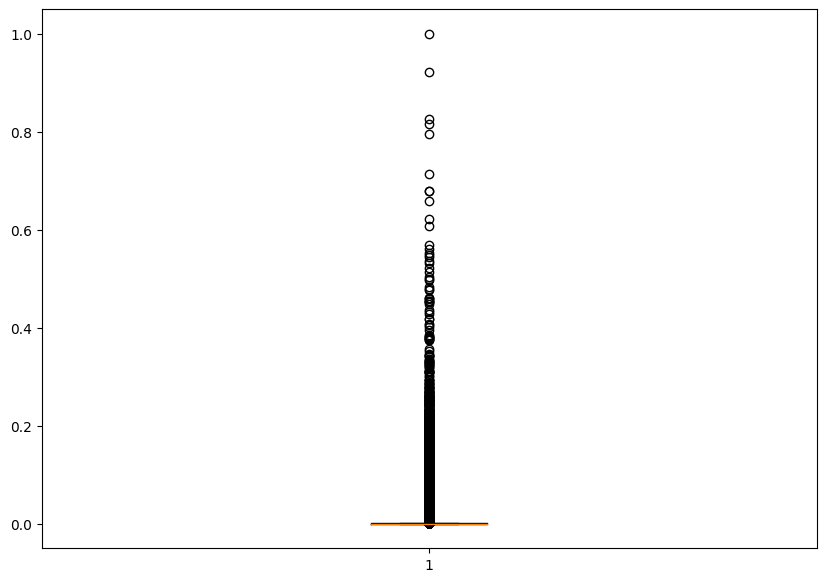

In [120]:
fig = plt.figure(figsize =(10, 7))
bp = plt.boxplot(np.ravel(result))
plt.show()

In [121]:
q1, q2, q3 = np.percentile(result, [25, 50, 75])
iqr = q3 - q1
maximum = q3 + 10 * iqr
q1,q2,q3,maximum

(0.0, 0.0, 0.0006311494362307712, 0.006942643798538484)

In [48]:
# target_baseline = 1
# target_sbj = 0
# final_res = None
# count = 0

# if target_baseline == 0:
#     label_baseline = 'AD'
# else:
#     label_baseline = 'CN'
    
# # with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
# with open(path + str(label_baseline) + '_' + str(gender_anchor) + '_' + str(new_target_age) + '.txt', 'r') as f:
#     for filename in f.readlines():
#         filename = filename.strip('\n')
#         imagename = filename.split('\\')[-1]
#         baseline_filename = 'D:\\Lab\\ig\\pairs_diff\\' + 'ww' + imagename
#         img, baseline, atlas = apply_mask_baseline(sbj_filename, baseline_filename)
#         # baseline = edited(baseline, n = 0.5)
#         y_pred_bs = model.predict(tf.expand_dims(baseline , axis = 0))
#         y_pred_img = model.predict(tf.expand_dims(img , axis = 0))
#         # print(y_pred_img, y_pred_bs)
#         if np.argmax(y_pred_img) != target_sbj or np.argmax(y_pred_bs) != target_baseline:
#             continue
#         # print(y_pred_img, y_pred_bs)
#         total = None
#         for i in tqdm(range(0, m_steps, 20)):
#             interpolated_img = interpolated_image(
#             baseline=baseline,
#             image=img,
#             alphas=alphas[i : i + 20])

#             path_gradient = compute_gradients(interpolated_img,  target_sbj)
#             mean = tf.expand_dims(integral_approximation(gradients=path_gradient), axis = 0)

#             if total == None:
#                 total = mean
#             else:
#                 total = tf.concat([total, mean], axis = 0)
#         total = tf.math.reduce_mean(total, axis = 0)
#         ig = (img - baseline) * total.numpy()
#         result = abs(ig)
#         # result[result < 0] = 0

#         result = (result - result.min()) / (result.max() - result.min())
#         q1, q2, q3 = np.percentile(result, [25, 50, 75])
#         iqr = q3 - q1
#         maximum = q3 + 10 * iqr
#         temp2 = copy.deepcopy(result)
#         temp2[result < maximum] = 0
#         blurred3 = cv2.medianBlur(temp2,1)
#         blurred3 = (blurred3 - blurred3.min()) / (blurred3.max() - blurred3.min())
        
#         if count == 0:
#             final_res = blurred3[np.newaxis, :]
#         else: 
#             final_res = np.concatenate((blurred3[np.newaxis, :], final_res), axis = 0)
#         count += 1
#     res = np.mean(final_res, axis=0)
#     img = apply_mask_img(sbj_filename)
#     image = nib.load(sbj_filename)
#     ni_img = nib.Nifti1Image(res, image.affine)
#     nib.save(ni_img, 'D:\\Lab\\ig\\pairs_diff\\output_CN_AD_M.nii')
#     nib.save(nib.Nifti1Image(atlas, image.affine), 'D:\\Lab\\ig\\pairs_diff\\atlas_AD_M.nii')
#     nib.save(nib.Nifti1Image(img, image.affine), 'D:\\Lab\\ig\\pairs_diff\\original_AD_M.nii')

[[1.5643677e-11 2.9707726e-11 1.3477995e-05 4.9199257e-06 9.1275099e-11
  1.2850061e-11 1.1350512e-06 1.1800484e-13 9.9217394e-14 1.2075730e-11
  8.0773374e-11 6.7830378e-08 8.5257339e-09 6.4171439e-11 6.6398672e-05
  1.0765424e-10 1.4991635e-12 5.1490107e-10 1.1210102e-10 3.0937361e-08
  2.6202778e-11 1.2575689e-10 7.2065444e-11 4.8831345e-11 3.4956017e-11
  1.5565824e-10 6.2672240e-07 3.1751506e-13 2.1002353e-10 4.1520445e-09
  4.8344050e-12 3.4548323e-10 1.0943726e-05 1.1380638e-11 1.2175573e-07
  3.8148040e-10 1.9526849e-11 3.9184857e-07 2.1422503e-07 1.1775028e-10
  7.9289852e-03 9.9191940e-01 2.4712055e-10 1.3691132e-12 2.2838211e-19
  3.5929467e-12 2.4004512e-11 4.1332488e-08 4.0669522e-05 2.0693123e-13
  2.3400666e-09 3.5860970e-10 1.0008879e-11 4.6066127e-08 1.6781415e-12
  1.4317627e-11 1.4104947e-07 1.7703339e-10 4.3600865e-09 3.9311616e-15
  1.2299856e-05 3.9576695e-10 1.1867496e-10 7.7655703e-12]] [[2.83797726e-06 4.18472564e-06 2.77725700e-03 1.95010507e-03
  6.19962202e-

AxisError: axis 0 is out of bounds for array of dimension 0

# Other saliency method

In [78]:
grad_model = tf.keras.models.Model([model.inputs], [model.get_layer('conv3d_25').output, model.output])
def make_gradcam_heatmap(img_array, grad_model, target_class=None):

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        top_class_channel = preds[:, 0]

        grads = tape.gradient(top_class_channel, last_conv_layer_output)

        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2, 3))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
    
    return np.squeeze(heatmap)

def make_gradcam_plus_heatmap(img_array, grad_model, target_class=None):

    with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape:
                last_conv_layer_output, preds = grad_model(img_array)
                tape.watch(last_conv_layer_output)
                tape2.watch(last_conv_layer_output)
                tape1.watch(last_conv_layer_output)

                top_class_channel = preds[:, 0]

                grads = tape.gradient(top_class_channel, last_conv_layer_output)
            grads2 = tape2.gradient(grads, last_conv_layer_output)
        grads3 = tape1.gradient(grads2, last_conv_layer_output)
    global_sum = np.sum(last_conv_layer_output, axis=(0, 1, 2, 3))

    alpha_num = grads2[0]
    alpha_denom = grads2[0]*2.0 + grads3[0]*global_sum
    alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

    alphas = alpha_num/alpha_denom
    alpha_normalization_constant = np.sum(alphas, axis=(0,1, 2))
    alpha_normalization_constant = np.where(alpha_normalization_constant != 0.0, alpha_normalization_constant, 1e-10)
    alphas /= alpha_normalization_constant

    weights = np.maximum(grads[0], 0.0)

    deep_linearization_weights = np.sum(weights*alphas, axis=(0,1,2))
    grad_cam_map = np.sum(deep_linearization_weights*last_conv_layer_output[0], axis=3)
    heatmap = np.maximum(grad_cam_map, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
        
    return heatmap

def make_eigen_cam_heatmap(img_array, grad_model, target_class=None):
    last_conv_layer_output, preds = grad_model(img_array)
    U, S, VT = np.linalg.svd(last_conv_layer_output, full_matrices=True)
    projection = last_conv_layer_output @ VT[:,0,:]


    heatmap = np.maximum(tf.reduce_mean(projection[0], axis=-1), 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
        
    return heatmap

def make_eigen_gradcam_heatmap(img_array, grad_model, target_class=None):

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        tape.watch(last_conv_layer_output)

        top_class_channel = preds[:, 0]

        grads = tape.gradient(top_class_channel, last_conv_layer_output)
    activations = grads * last_conv_layer_output
    U, S, VT = np.linalg.svd(activations, full_matrices=True)
    projection = activations @ VT[:,0,:]


    heatmap = np.maximum(tf.reduce_mean(projection[0], axis=-1), 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat
        
    return heatmap

def show_heatmap(img_array, grad_model, eigen = False, plus = True, target_class=None):
    if eigen:
        if not plus:
            heatmap = make_eigen_cam_heatmap(img_array, grad_model, target_class)
        else:
            heatmap = make_eigen_gradcam_heatmap(img_array, grad_model, target_class)
    else:
        if not plus:
            heatmap = make_gradcam_heatmap(img_array, grad_modell, target_class)
        else:
            heatmap = make_gradcam_plus_heatmap(img_array, grad_model, target_class)
        
    return heatmap

In [86]:
method = ['gradcam','gradcam_plus','eigen','eigen_gradcam']
for index, m in tqdm(enumerate(method)):
    if index == 0: 
        eigen, plus = False, False
    elif index == 1:
        eigen, plus = False, True
    elif index == 2:
        eigen, plus = True, False
    else:
        eigen, plus = True, True
    dr = 'D:\\Lab\\ig\\all_subject_AD\\'
    # for idx in range(len(data_test['Links'])):
    for imagename in sid_set_dict.keys():
        filename = sid_set_dict[imagename][3]
        img = apply_mask_one(filename)
        y_pred_img = model.predict(tf.expand_dims(img, axis=0))[0][0]
        if y_pred_img <= 0.5:
            continue
    
        heatmap = show_heatmap(tf.expand_dims(img, axis=0), grad_model)
        heatmap=resize(heatmap,(96,96,96))
        
        # if not os.path.exists(dr + imae):
        #     os.mkdir(dr + sid)
        image = nib.load(filename)
        ni_img = nib.Nifti1Image(heatmap, image.affine)
        nib.save(ni_img, dr + imagename + '\\output_' + m + '.nii')

0it [00:00, ?it/s]

In [262]:
fig, ax = plt.subplots(1,3, figsize = (12, 6))
ax[0].imshow(diff_img1[:,:,diff_img1.shape[2]//2], cmap='gray')
ax[1].imshow(diff_img1[:,diff_img1.shape[1]//2, :], cmap='gray')
ax[2].imshow(diff_img1[diff_img1.shape[0]//2], cmap='gray')

'005_S_0814'